# Data

In [16]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/PARus" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

In [17]:
%%capture
%%bash
# add tree package for fancy directory display
apt-get install tree

In [18]:
# display the content of the folder
!tree

.
├── data
│   ├── a
│   │   └── __MACOSX
│   ├── ip
│   ├── __MACOSX
│   │   └── PARus
│   ├── ories and files
│   ├── PARus
│   │   ├── test.jsonl
│   │   ├── train.jsonl
│   │   └── val.jsonl
│   └── ple_data
└── temp.zip

6 directories, 7 files


In [19]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""
        return pd.read_json(path_or_buf=self.path, lines=True)

# Data Exploration

In [20]:
handler = JSONL_handler('data/PARus/train.jsonl')
df = handler.to_pandas()

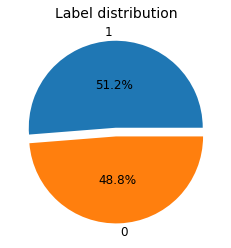

1    205
0    195
Name: label, dtype: int64

In [72]:
import matplotlib.pyplot as plt
plt.title('Label distribution', fontsize=14)
plt.pie(df['label'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df['label'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12))
plt.show()

df['label'].value_counts()

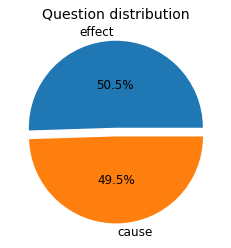

effect    202
cause     198
Name: question, dtype: int64

In [73]:
plt.title('Question distribution', fontsize=14)
plt.pie(df['question'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df['question'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12))
plt.show()

df['question'].value_counts()

## Short summary

In [ ]:
!pip install razdel
!pip install natasha

In [35]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)




In [42]:
tokenize('Яблоко вкусное было')

(['Яблоко', 'вкусное', 'было'], ['яблоко', 'вкусный', 'быть'])

In [55]:
def lemmatize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    lemmas = [token.lemma for token in doc.tokens]
    return lemmas

In [56]:
df['premise_lemmas'] = df.premise.apply(lemmatize)
df['choice1_lemmas'] = df.choice1.apply(lemmatize)
df['choice2_lemmas'] = df.choice2.apply(lemmatize)

In [57]:
df.head()

,premise,choice1,choice2,question,label,idx,premise_lemmas,choice1_lemmas,choice2_lemmas
0,Моё тело отбрасывает тень на траву.,Солнце уже поднялось.,Трава уже подстрижена.,cause,0,0,"[мой, тело, отбрасывать, тень, на, трава, .]","[солнце, уже, подняться, .]","[трава, уже, подстричь, .]"
1,Женщина снисходительно относилась к странному поведению подруги.,"Женщина знала, что её подруга переживает трудные времена.","Женщина чувствовала, что подруга пользуется её добротой.",cause,0,1,"[женщина, снисходительно, относиться, к, странный, поведение, подруга, .]","[женщина, знать, ,, что, ее, подруга, переживать, трудный, время, .]","[женщина, чувствовать, ,, что, подруга, пользоваться, она, доброта, .]"
2,Женщины встретились попить кофе.,Их кафе открылось в новом месте.,Им хотелось пересечься друг с другом.,cause,1,2,"[женщина, встретиться, попить, кофе, .]","[их, кафе, открыться, в, новый, место, .]","[они, хотеться, пересечься, друг, с, друг, .]"
3,Бегунья была в шортах.,Прогноз обещал высокую температуру.,Она планировала бежать вдоль пляжа.,cause,0,3,"[бегунья, быть, в, шорты, .]","[прогноз, обещать, высокий, температура, .]","[она, планировать, бежать, вдоль, пляж, .]"
4,Гости вечеринки прятались за диваном.,Это была вечеринка-сюрприз.,Это был день рождения.,cause,0,4,"[гость, вечеринка, прятаться, за, диван, .]","[это, быть, вечеринка-сюрприз, .]","[это, быть, день, рождение, .]"


In [58]:
df_first = df[df['label']==0]
df_second = df[df['label']==1]

In [59]:
df_first.head()

,premise,choice1,choice2,question,label,idx,premise_lemmas,choice1_lemmas,choice2_lemmas
0,Моё тело отбрасывает тень на траву.,Солнце уже поднялось.,Трава уже подстрижена.,cause,0,0,"[мой, тело, отбрасывать, тень, на, трава, .]","[солнце, уже, подняться, .]","[трава, уже, подстричь, .]"
1,Женщина снисходительно относилась к странному поведению подруги.,"Женщина знала, что её подруга переживает трудные времена.","Женщина чувствовала, что подруга пользуется её добротой.",cause,0,1,"[женщина, снисходительно, относиться, к, странный, поведение, подруга, .]","[женщина, знать, ,, что, ее, подруга, переживать, трудный, время, .]","[женщина, чувствовать, ,, что, подруга, пользоваться, она, доброта, .]"
3,Бегунья была в шортах.,Прогноз обещал высокую температуру.,Она планировала бежать вдоль пляжа.,cause,0,3,"[бегунья, быть, в, шорты, .]","[прогноз, обещать, высокий, температура, .]","[она, планировать, бежать, вдоль, пляж, .]"
4,Гости вечеринки прятались за диваном.,Это была вечеринка-сюрприз.,Это был день рождения.,cause,0,4,"[гость, вечеринка, прятаться, за, диван, .]","[это, быть, вечеринка-сюрприз, .]","[это, быть, день, рождение, .]"
8,Врач поставил неверный диагноз пациенту.,Пациент подал в суд на врача за халатность.,Пациент поделился с врачом конфиденциальной информацией.,effect,0,8,"[врач, поставить, неверный, диагноз, пациент, .]","[пациент, подать, в, суд, на, врач, за, халатность, .]","[пациент, поделиться, с, врач, конфиденциальный, информация, .]"


In [60]:
# [3, 5, 11, 15, 23, 26, 30, 32, 35, 49, 54, 88, 119, 135] # Посмотреть на после 150
# Full df
# df

In [63]:
df.iloc[[3, 5, 11, 15, 23, 26, 30, 32, 35, 49, 54, 88, 119, 135]][['premise', 'choice1', 'choice2', 'question', 'label']]

,premise,choice1,choice2,question,label
3,Бегунья была в шортах.,Прогноз обещал высокую температуру.,Она планировала бежать вдоль пляжа.,cause,0
5,Политик проиграл выборы.,Он использовал плохие лозунги.,Никто не голосовал за него.,cause,1
11,Пожилая женщина перенесла инсульт.,Её дочь пришла убираться в её доме.,"Её дочь переехала в её дом, чтобы заботиться о ней.",effect,1
15,Девушка ахнула.,Её друг пустил кубик льда вниз по её спине.,Её друг погладил её по спине.,cause,0
23,Хозяйка отменила праздник.,"Ей показалось, что у неё грипп.","Она переживала, что может подхватить грипп.",cause,0
26,Малышка стала капризничать.,Мать положила её спать.,Мать решила заплести ей косички.,effect,0
30,Женщина напевала про себя.,Она нервничала.,Она была в хорошем настроении.,cause,1
32,Полицейские направили оружие на беглеца.,Беглец упал на землю.,Беглец бросил ружьё.,effect,1
35,Человек сразу вскочил с постели.,Он хотел выключить будильник.,Он хотел погладить брюки перед работой.,cause,0
49,Дети опрокинули лампу.,У них был бой подушками.,Они прыгали на кровати.,cause,0


In [74]:
df[df['question']=='effect'].label.value_counts()

1    104
0     98
Name: label, dtype: int64

In [75]:
df[df['question']=='cause'].label.value_counts()

1    101
0     97
Name: label, dtype: int64